<a href="https://colab.research.google.com/github/schakosss/szakdoga-pm/blob/main/szakdoga_pm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#könvytárak importja
import numpy as np
import pandas as pd
import os
import warnings
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import kagglehub
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


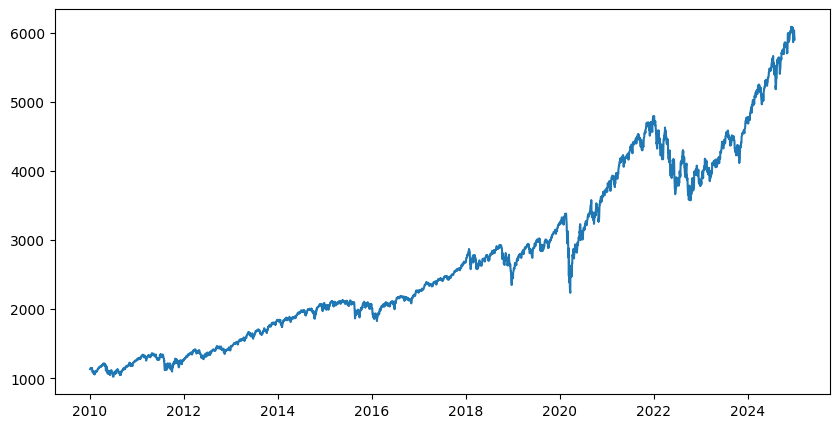

In [ ]:
#s&p500
sp = yf.download('^GSPC', start='2010-01-01', end='2024-12-31')
sp = sp[['Close']].rename(columns={'Close': 'Price'})
sp.reset_index(inplace=True)
sp.columns = ['Date', 'Value']
sp['Date'] = pd.to_datetime(sp['Date'])

plt.figure(figsize=(10, 5))
plt.plot(sp['Date'], sp['Value'])
plt.show()


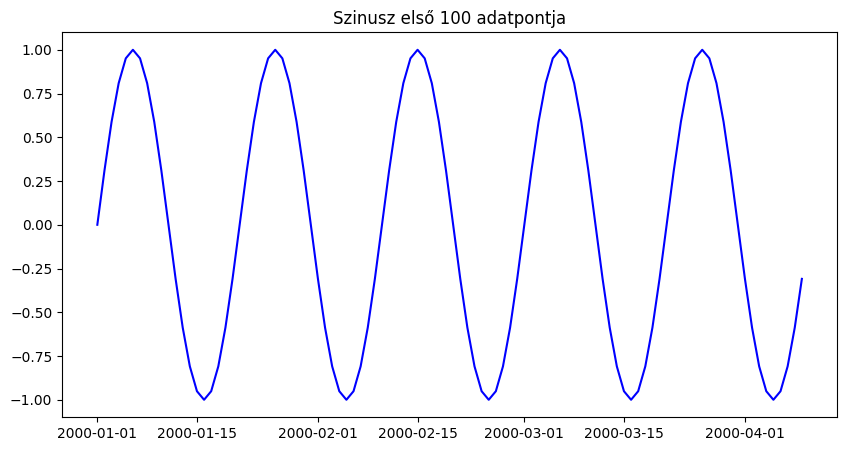

In [ ]:
#szinusz
szin = np.sin(2 * np.pi * 0.05 * np.arange(5000))
date = pd.date_range(start='2000-01-01', periods=5000, freq='D')

szinusz = pd.DataFrame({'Date': date, 'Value': szin})
szinusz['Date'] = pd.to_datetime(szinusz['Date'])

plt.figure(figsize=(10, 5))
plt.plot(szinusz['Date'][:100], szinusz['Value'][:100], color='blue')
plt.title('Szinusz első 100 adatpontja')
plt.show()

100%|██████████| 1.25M/1.25M [00:00<00:00, 2.36MB/s]

Extracting files...


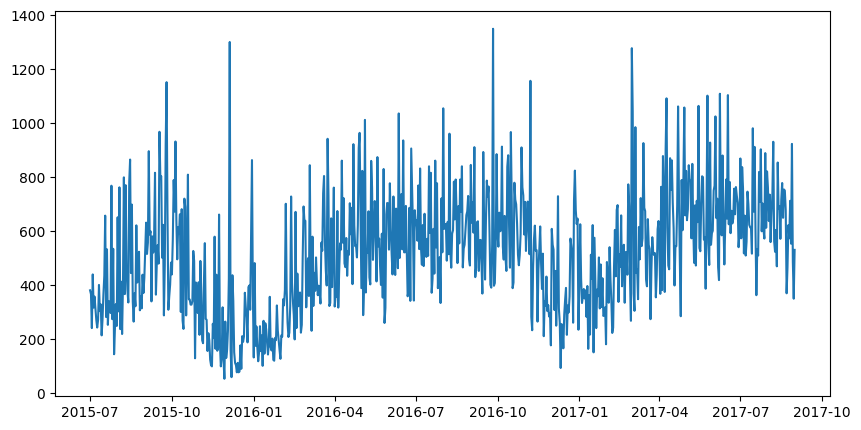

In [ ]:
#vendégéjszaka import-átalakítás-ábra
p = kagglehub.dataset_download("jessemostipak/hotel-booking-demand")
guest = pd.read_csv(p + "/hotel_bookings.csv")

guest['Value'] = guest['stays_in_weekend_nights'] + guest['stays_in_week_nights']
guest['Date'] = pd.to_datetime(guest['arrival_date_year'].astype(str) + '-' + guest['arrival_date_month'].astype(str) + '-' + guest['arrival_date_day_of_month'].astype(str), format='%Y-%B-%d', errors='coerce')
guest = guest[['Date', 'Value']].dropna() #eldobja ahol hiányos vmi
guest2 = guest.groupby('Date').sum().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(guest2['Date'], guest2['Value'])
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving export (5).xlsx to export (5).xlsx
Saving export (4).xlsx to export (4).xlsx
Saving export (3).xlsx to export (3).xlsx


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
<ipython-input-6-f8ad883d9c00>:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.date

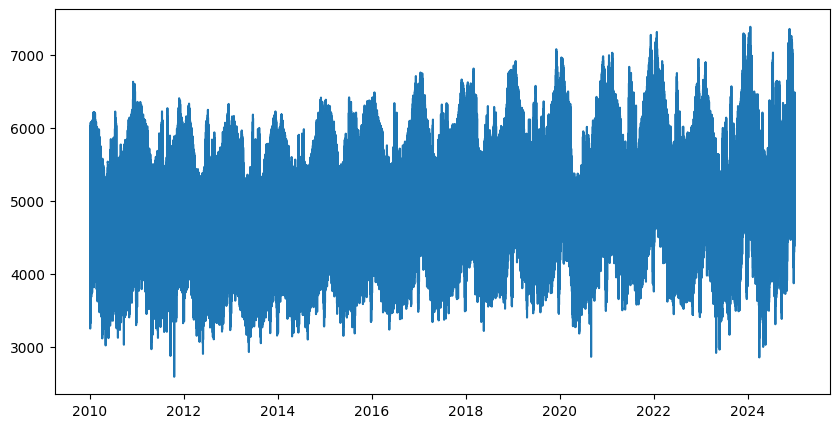

In [ ]:
#áramfogyasztás import-átalakítás-ábra
fajlok = ['export (3).xlsx', 'export (4).xlsx', 'export (5).xlsx']

lista = []
for f in fajlok:
    electric_part = pd.read_excel(f)[['Időpont', 'Bruttó tény rendszerterhelés']]
    lista.append(electric_part)

electric = pd.concat(lista, ignore_index=True)
electric.columns = ['Date', 'Value']
electric['Date'] = pd.to_datetime(electric['Date'])

plt.figure(figsize=(10, 5))
plt.plot(electric['Date'], electric['Value'])
plt.show()


In [ ]:
#mindegyik adatsor átalakítása a modellekhez
guest2 = guest2.set_index('Date')
electric = electric.set_index('Date')
sp = sp.set_index('Date')
szinusz = szinusz.set_index('Date')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

MSE: 18436.448082711224
RMSE: 135.78088261132797
MAE: 107.3547573548306
R2 Score: 0.04471488367192267


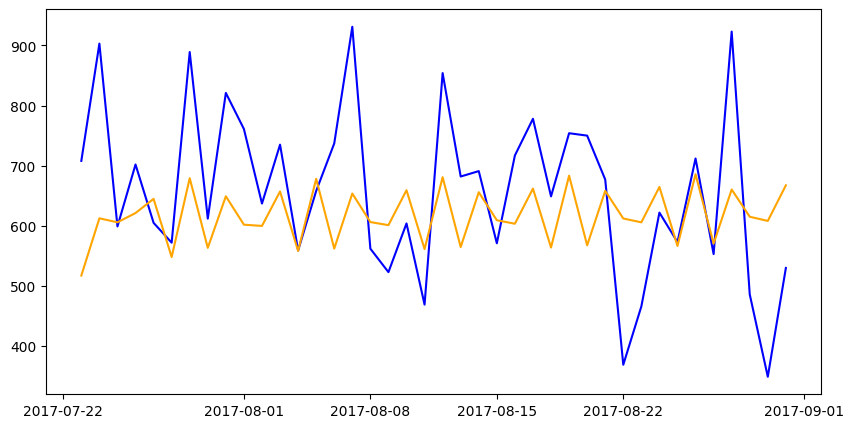

In [ ]:
guest_arima = guest2.copy()
guest_arima = guest_arima.dropna()

train = guest_arima[:int(len(guest_arima) * 0.95)]
test = guest_arima[int(len(guest_arima) * 0.95):]

model = ARIMA(train, order=(5, 2, 3))
fitted = model.fit()
pred = fitted.forecast(steps=len(test))
pred.index = test.index

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 1.3613830149058e-05
RMSE: 0.003689692419302455
MAE: 0.0028878600176480947
R2 Score: 0.9999727375629012


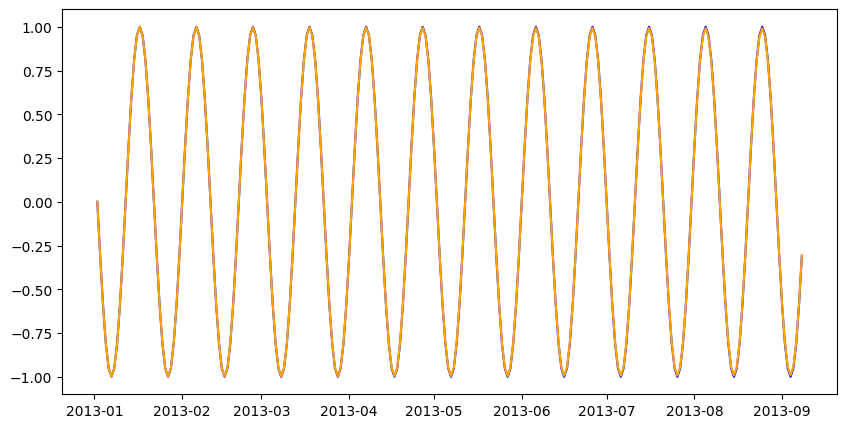

In [ ]:
szinusz_arima = szinusz.copy()
szinusz_arima = szinusz_arima.dropna()

train = szinusz_arima[:int(len(szinusz_arima) * 0.95)]
test = szinusz_arima[int(len(szinusz_arima) * 0.95):]

model = ARIMA(train, order=(5, 1, 0))
fitted = model.fit()
pred = fitted.forecast(steps=len(test))
pred.index = test.index

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 96502.48275829946
RMSE: 310.64848745535437
MAE: 255.74585599616856
R2 Score: -0.07801510230935604


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


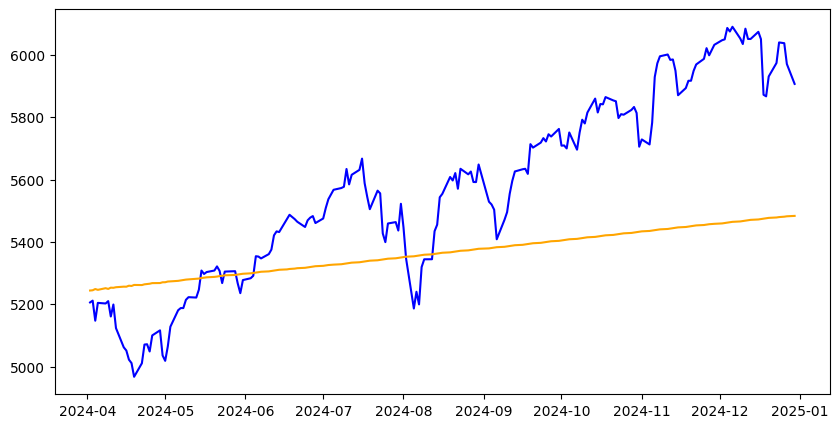

In [ ]:
sp_arima = sp.copy()
sp_arima = sp_arima.dropna()

train = sp_arima[:int(len(sp_arima) * 0.95)]
test = sp_arima[int(len(sp_arima) * 0.95):]

model = ARIMA(train, order=(5, 2, 3))
fitted = model.fit()
pred = fitted.forecast(steps=len(test))
pred.index = test.index

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

MSE: 1271959.8161869056
RMSE: 1127.8119595867502
MAE: 898.7023073394528
R2 Score: -0.9384974920622828


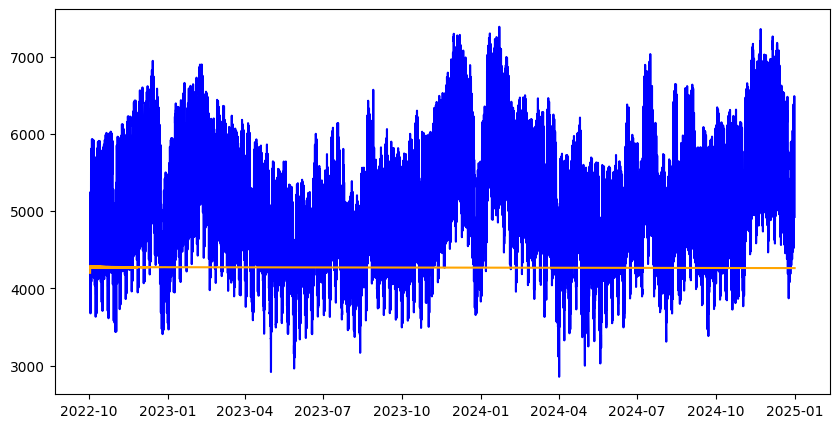

In [ ]:
electric_arima = electric.copy()
electric_arima = electric_arima.dropna()

train = electric_arima[:int(len(electric_arima) * 0.85)]
test = electric_arima[int(len(electric_arima) * 0.85):]

model = ARIMA(train, order=(5, 2, 3))
fitted = model.fit()
pred = fitted.forecast(steps=len(test))
pred.index = test.index

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 0.000000
RMSE: 0.000000
MAE: 0.000000
R2 Score: 1.000000


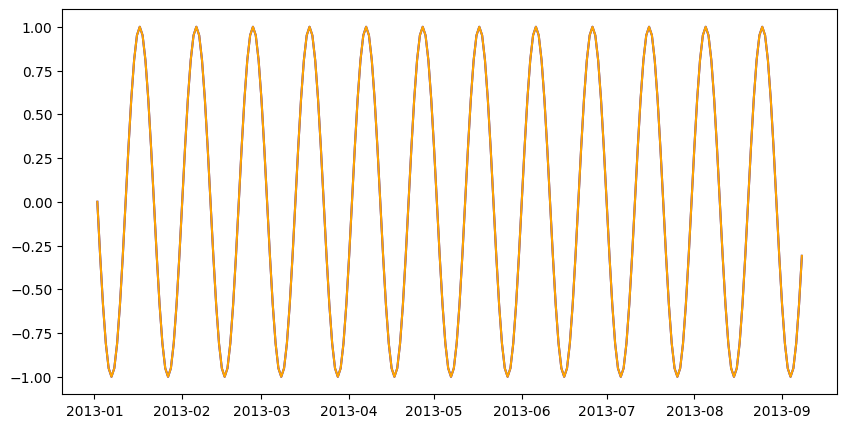

In [ ]:
szinusz_sarima = szinusz.copy()
szinusz_sarima = szinusz_sarima.dropna()

train_size = int(len(szinusz_sarima) * 0.95)
train = szinusz_sarima.iloc[:train_size]
test = szinusz_sarima.iloc[train_size:]

model = SARIMAX(train,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 20),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit()
pred = fit.forecast(steps=len(test))
pred.index = test.index

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 42047.429666
RMSE: 205.054699
MAE: 171.182854
R2 Score: -0.725261


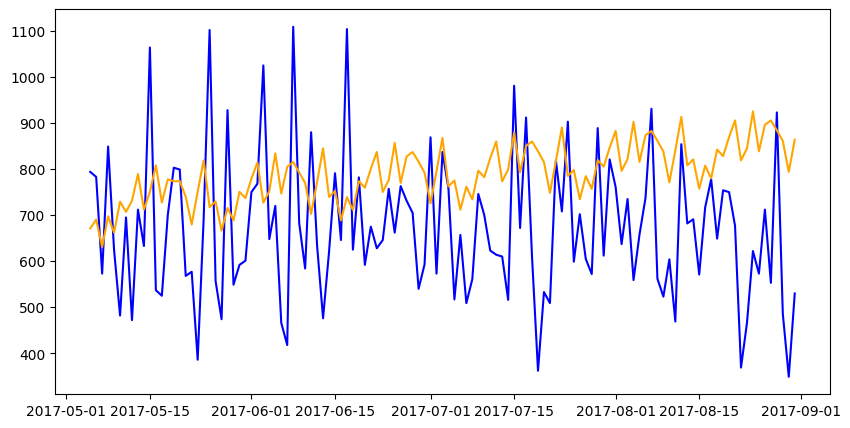

In [ ]:
guest_sarima = guest2.copy()
guest_sarima = guest_sarima.dropna()

train_size = int(len(guest_sarima) * 0.85)
train = guest_sarima.iloc[:train_size]
test = guest_sarima.iloc[train_size:]

model = SARIMAX(train,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 20),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit(disp=False)
pred = fit.forecast(steps=len(test))
pred.index = test.index

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 947417.923422
RMSE: 973.353956
MAE: 796.278690
R2 Score: -0.981617


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


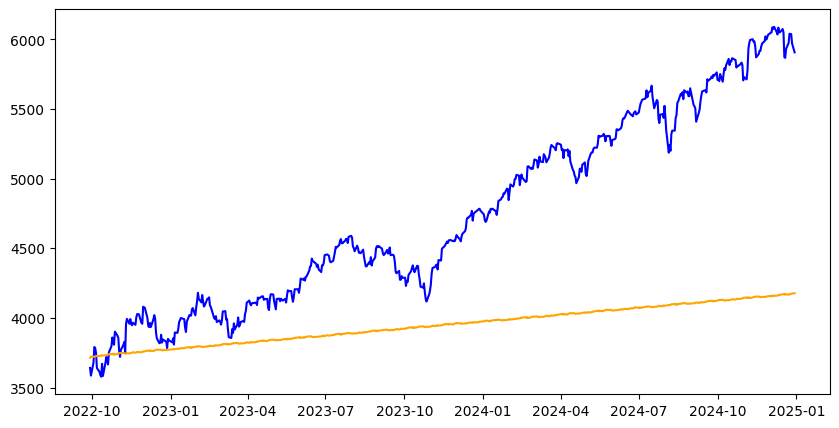

In [ ]:
sp_sarima = sp.copy()
sp_sarima = sp_sarima.dropna()

train_size = int(len(sp_sarima) * 0.85)
train = sp_sarima.iloc[:train_size]
test = sp_sarima.iloc[train_size:]

model = SARIMAX(train,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 30),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit(disp=False)
pred = fit.forecast(steps=len(test))
pred.index = test.index

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


MSE: 386226.955718
RMSE: 621.471605
MAE: 519.668750
R2 Score: -0.066289


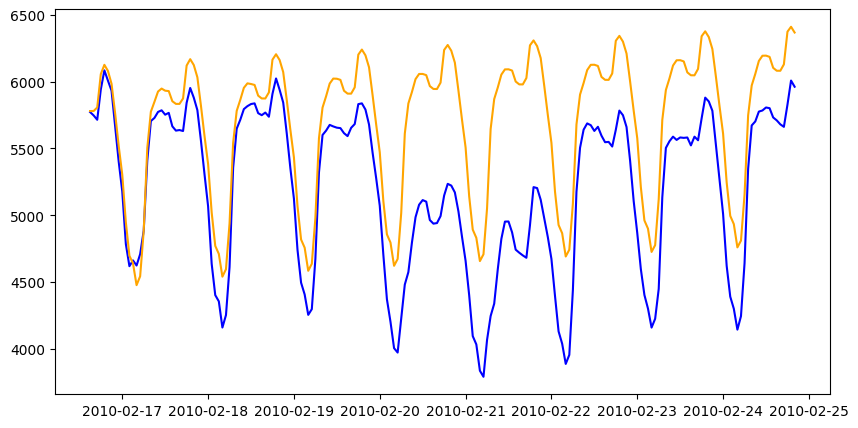

In [ ]:
electric_sarima = electric.copy()
electric_sarima = electric_sarima.dropna()

sample_size = int(len(electric_sarima) * 0.01)
electric_sarima = electric_sarima.iloc[:sample_size]

train_size = int(len(electric_sarima) * 0.85)
train = electric_sarima.iloc[:train_size]
test = electric_sarima.iloc[train_size:]

model = SARIMAX(train,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit(disp=False)
pred = fit.forecast(steps=len(test))
pred.index = test.index

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


In [ ]:
#prophetnek megfelelő formátummá alakítás

szinusz_prophet = szinusz.copy()
szinusz_prophet = szinusz_prophet.reset_index()
szinusz_prophet = szinusz_prophet.rename(columns={'Date': 'ds', 'Value': 'y'})
szinusz_prophet['ds'] = pd.to_datetime(szinusz_prophet['ds'])
szinusz_prophet = szinusz_prophet[['ds', 'y']]

guest2_prophet = guest2.copy()
guest2_prophet = guest2_prophet.reset_index()  # ha 'Date' az index
guest2_prophet = guest2_prophet.rename(columns={'Date': 'ds', 'Value': 'y'})
guest2_prophet['ds'] = pd.to_datetime(guest2_prophet['ds'])
guest2_prophet = guest2_prophet[['ds', 'y']]

sp_prophet = sp.copy()
sp_prophet = sp_prophet.reset_index()
sp_prophet = sp_prophet.rename(columns={'Date': 'ds', 'Value': 'y'})
sp_prophet['ds'] = pd.to_datetime(sp_prophet['ds'])
sp_prophet = sp_prophet[['ds', 'y']]

electric_prophet = electric.copy()
electric_prophet = electric_prophet.reset_index()
electric_prophet = electric_prophet.rename(columns={'Date': 'ds', 'Value': 'y'})
electric_prophet['ds'] = pd.to_datetime(electric_prophet['ds'], utc=True)
electric_prophet = electric_prophet[['ds', 'y']]




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jih00dc/dzqktimc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jih00dc/a3ttti2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75608', 'data', 'file=/tmp/tmp1jih00dc/dzqktimc.json', 'init=/tmp/tmp1jih00dc/a3ttti2b.json', 'output', 'file=/tmp/tmp1jih00dc/prophet_model2tf4xa5r/prophet_model-20250502172208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 0.000000
RMSE: 0.000006
MAE: 0.000006
R2 Score: 1.000000


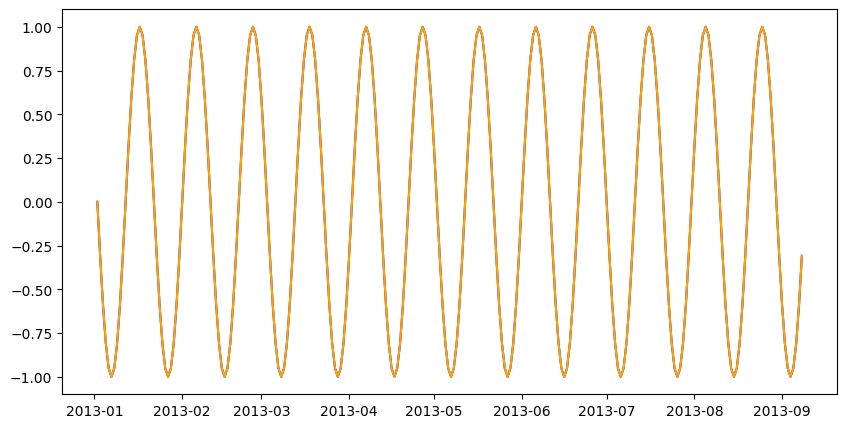

In [ ]:
szinusz_prophet = szinusz.copy()
szinusz_prophet = szinusz_prophet.reset_index().rename(columns={"Date": "ds", "Value": "y"})
szinusz_prophet["ds"] = pd.to_datetime(szinusz_prophet["ds"])

train_size = int(len(szinusz_prophet) * 0.95)
train = szinusz_prophet.iloc[:train_size]
test = szinusz_prophet.iloc[train_size:]

model = Prophet()
model.add_seasonality(name='sin_period', period=20, fourier_order=10)
model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq='D')
pred = model.predict(future)

y_true = test['y'].values
y_pred = pred['yhat'][-len(test):].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(test['ds'], y_true, color='blue')
plt.plot(test['ds'], y_pred, color='orange')
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwuh4jg7f/6myv3sgt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwuh4jg7f/3gc7u5qa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=425', 'data', 'file=/tmp/tmpwuh4jg7f/6myv3sgt.json', 'init=/tmp/tmpwuh4jg7f/3gc7u5qa.json', 'output', 'file=/tmp/tmpwuh4jg7f/prophet_modelabm8x1rp/prophet_model-20250503102047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 21911.532991
RMSE: 148.025447
MAE: 118.962083
R2 Score: 0.100941


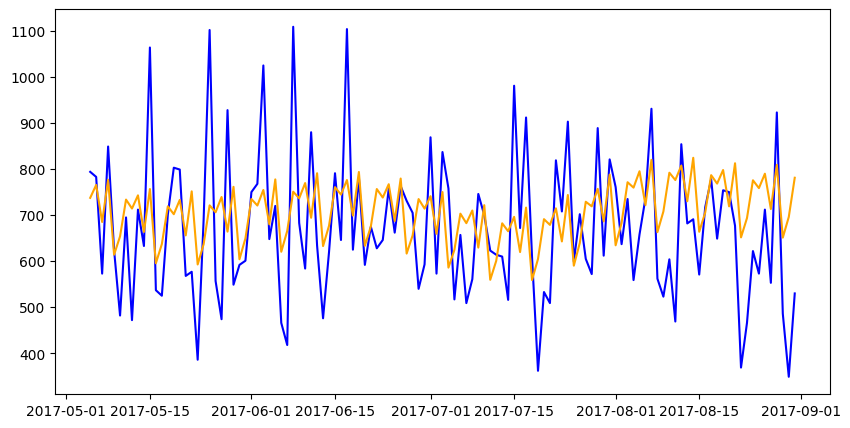

In [ ]:
guest2_prophet = guest2.copy()
guest2_prophet = guest2_prophet.reset_index().rename(columns={"Date": "ds", "Value": "y"})
guest2_prophet["ds"] = pd.to_datetime(guest2_prophet["ds"])

train_size = int(len(guest2_prophet) * 0.85)
train = guest2_prophet.iloc[:train_size]
test = guest2_prophet.iloc[train_size:]

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(train)

future = model.make_future_dataframe(periods=len(test), freq='D', include_history=False)
pred = model.predict(future)

y_true = test['y'].values
y_pred = pred['yhat'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 Score: {r2:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(test['ds'], y_true, color='blue')
plt.plot(test['ds'], y_pred, color='orange')
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpetrgebrm/a8r5imup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpetrgebrm/1vzjxy7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80172', 'data', 'file=/tmp/tmpetrgebrm/a8r5imup.json', 'init=/tmp/tmpetrgebrm/1vzjxy7a.json', 'output', 'file=/tmp/tmpetrgebrm/prophet_model_f7g6uau/prophet_model-20250503171101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


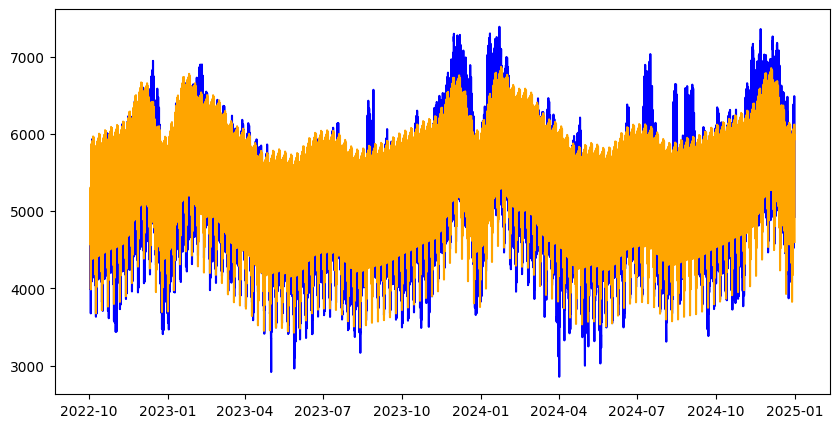

In [ ]:

electric_prophet['ds'] = pd.to_datetime(electric_prophet['ds']).dt.tz_localize(None)

train_size = int(len(electric_prophet) * 0.85)
train = electric_prophet.iloc[:train_size]
test = electric_prophet.iloc[train_size:]

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train)

pred = model.predict(model.make_future_dataframe(periods=len(test), freq='H', include_history=False))

plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], color='blue')
plt.plot(pred['ds'], pred['yhat'], color='orange')
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpetrgebrm/cxds6m9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpetrgebrm/6o7_wl22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14493', 'data', 'file=/tmp/tmpetrgebrm/cxds6m9h.json', 'init=/tmp/tmpetrgebrm/6o7_wl22.json', 'output', 'file=/tmp/tmpetrgebrm/prophet_modeljf1z3kdw/prophet_model-20250503171321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


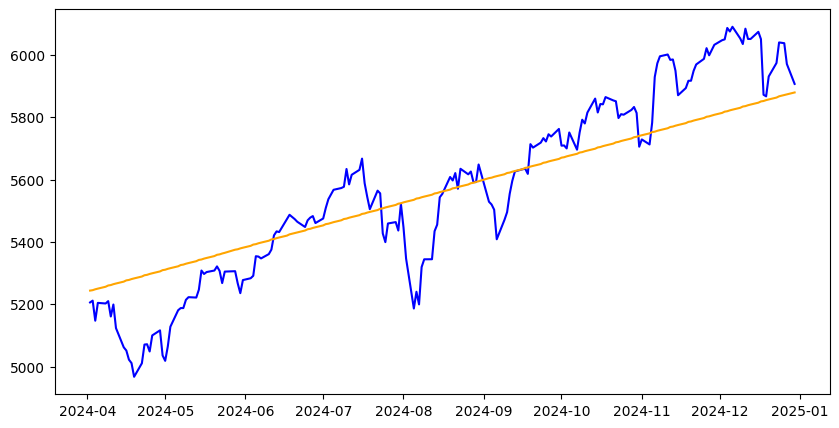

In [ ]:
# prophet-s&p500

train_size = int(len(sp_prophet) * 0.95)
train = sp_prophet.iloc[:train_size]
test = sp_prophet.iloc[train_size:]

model = Prophet(
    changepoint_range=0.9,
    changepoint_prior_scale=0.5,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(train)

future = pd.DataFrame({'ds': test['ds']})
pred = model.predict(future)

last_train = train['y'].iloc[-1]
pred['yhat'] += (last_train - pred['yhat'].iloc[0])

plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], color='blue')
plt.plot(pred['ds'], pred['yhat'], color='orange')
plt.show()


MSE: 44478.05498099822
RMSE: 210.8982099995119
MAE: 180.45543092608847
R2 Score: -0.824992666276116


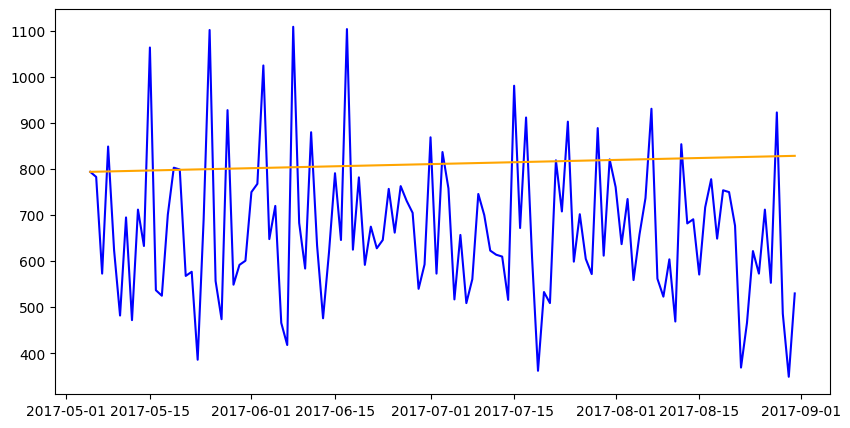

In [ ]:
guest_lr = guest2.copy()

train_size = int(len(guest_lr) * 0.85)
train = guest_lr.iloc[:train_size].copy()
test = guest_lr.iloc[train_size:].copy()

train['t'] = np.arange(len(train))
test['t'] = np.arange(len(train), len(train) + len(test))

model = LinearRegression()
model.fit(train[['t']], train['Value'])

pred = model.predict(test[['t']])
pred = pd.Series(pred, index=test.index)

offset = test['Value'].iloc[0] - pred.iloc[0]
pred += offset

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


MSE: 0.5000000022317522
RMSE: 0.7071067827646347
MAE: 0.6313751572998333
R2 Score: -0.0012772644432421654


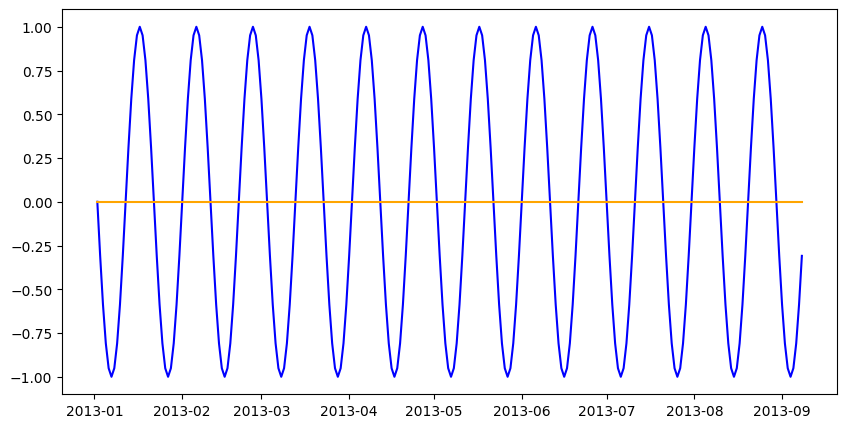

In [ ]:
# LINREG – szinusz

szin_lr = szinusz.copy()

train_size = int(len(szin_lr) * 0.95)
train = szin_lr.iloc[:train_size].copy()
test = szin_lr.iloc[train_size:].copy()

train['t'] = np.arange(len(train))
test['t'] = np.arange(len(train), len(train) + len(test))

model = LinearRegression()
model.fit(train[['t']], train['Value'])

pred = model.predict(test[['t']])
pred = pd.Series(pred, index=test.index)

offset = test['Value'].iloc[0] - pred.iloc[0]
pred += offset

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


MSE: 1227468.5696127147
RMSE: 1107.9118058820002
MAE: 881.2962711092098
R2 Score: -0.8706917573171842


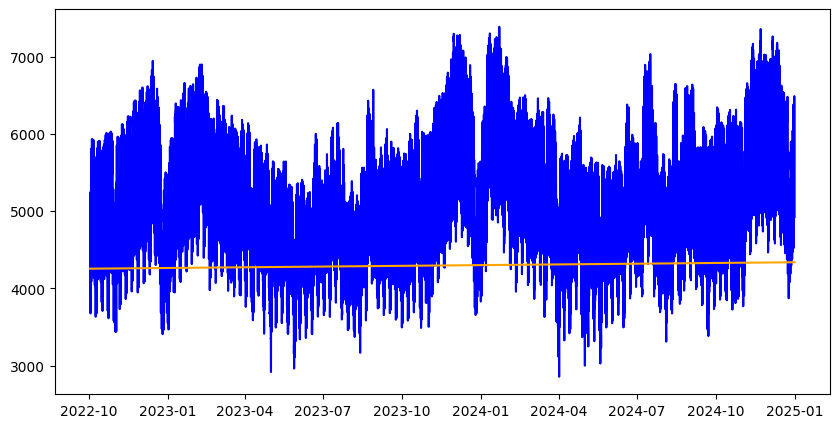

In [ ]:
electric_lr = electric.copy()
electric_lr = electric_lr.dropna()

train_size = int(len(electric_lr) * 0.85)
train = electric_lr.iloc[:train_size].copy()
test = electric_lr.iloc[train_size:].copy()

train['t'] = np.arange(len(train))
test['t'] = np.arange(len(train), len(train) + len(test))

model = LinearRegression()
model.fit(train[['t']], train['Value'])

pred = model.predict(test[['t']])
pred = pd.Series(pred, index=test.index)

offset = test['Value'].iloc[0] - pred.iloc[0]
pred += offset

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


MSE: 946841.8649003251
RMSE: 973.0579966786795
MAE: 815.7457605749104
R2 Score: -0.9804117276972746


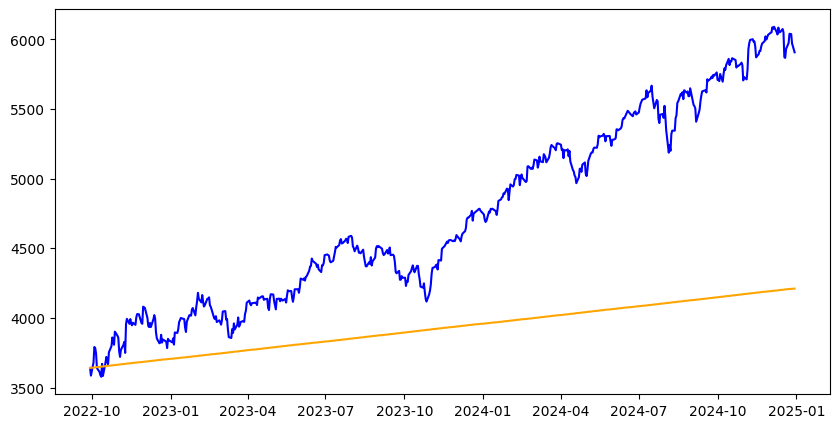

In [ ]:
# LinReg - S&P
sp_lr = sp.copy()

train_size = int(len(sp_lr) * 0.85)
train = sp_lr.iloc[:train_size].copy()
test = sp_lr.iloc[train_size:].copy()

train['t'] = np.arange(len(train))
test['t'] = np.arange(len(train), len(train) + len(test))

model = LinearRegression()
model.fit(train[['t']], train['Value'])

pred = model.predict(test[['t']])
pred = pd.Series(pred, index=test.index)

offset = test['Value'].iloc[0] - pred.iloc[0]
pred += offset

mse = mean_squared_error(test['Value'], pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Value'], pred)
r2 = r2_score(test['Value'], pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Value'], color='blue')
plt.plot(pred.index, pred, color='orange')
plt.show()


MSE: 1407788.963192295
RMSE: 1186.5028289862166
MAE: 991.333390949234
R2 Score: -2.3013871397185044


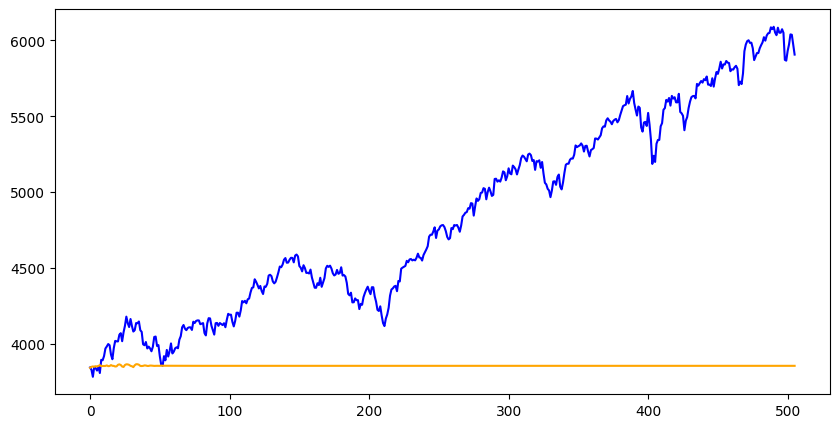

In [ ]:
#randomforest sp

sp_rf = sp.copy()
window_size = 60

train = sp_rf[:int(len(sp_rf) * 0.85)]
test = sp_rf[int(len(sp_rf) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

walk = test['Value'].values[:window_size].copy()
pred = []
for i in range(len(test['Value']) - window_size):
    x = walk.reshape(1, -1)
    p = model.predict(x)[0]
    pred.append(p)
    walk = np.append(walk[1:], p)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


MSE: 3.607467569540146e-27
RMSE: 6.006219750841743e-14
MAE: 4.374570994411347e-14
R2 Score: 1.0


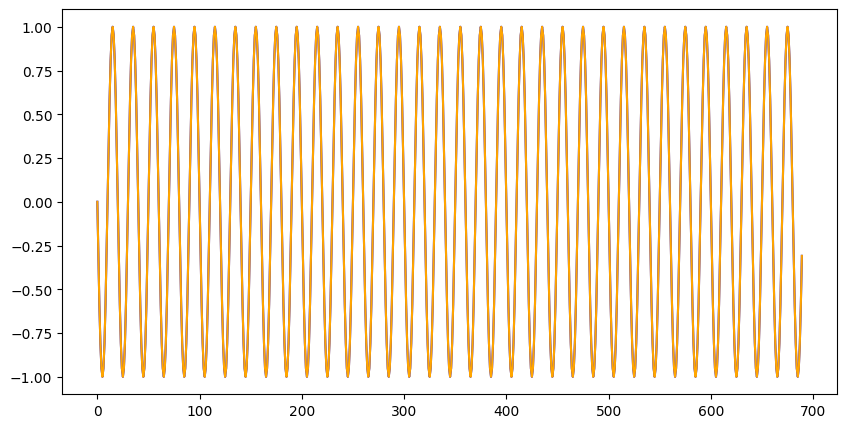

In [ ]:
#randomforest szinusz
szinusz_rf = szinusz.copy()
window_size = 60

train = szinusz_rf[:int(len(szinusz_rf) * 0.85)]
test = szinusz_rf[int(len(szinusz_rf) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

walk = test['Value'].values[:window_size].copy()
pred = []
for i in range(len(test['Value']) - window_size):
    x = walk.reshape(1, -1)
    p = model.predict(x)[0]
    pred.append(p)
    walk = np.append(walk[1:], p)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


MSE: 19778.82068855932
RMSE: 140.63719525274712
MAE: 113.03720338983051
R2 Score: 0.019107720705509257


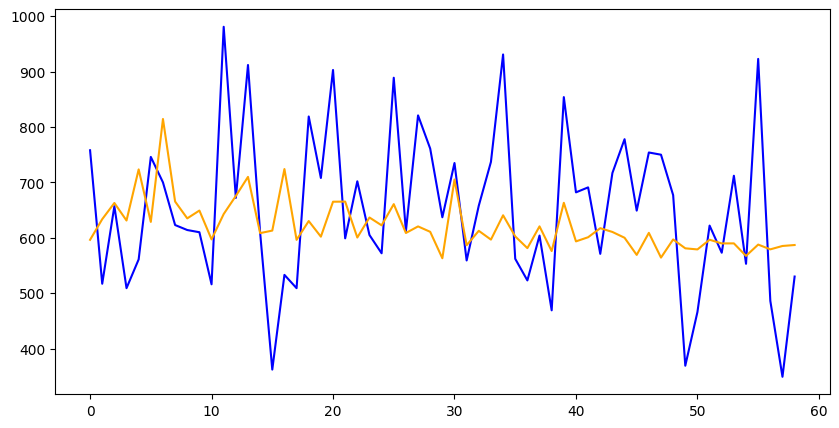

In [ ]:
#randomforest guest
guest_rf = guest2.copy()
window_size = 60

train = guest_rf[:int(len(guest_rf) * 0.85)]
test = guest_rf[int(len(guest_rf) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X, y)

walk = test['Value'].values[:window_size].copy()
pred = []
for i in range(len(test['Value']) - window_size):
    x = walk.reshape(1, -1)
    p = model.predict(x)[0]
    pred.append(p)
    walk = np.append(walk[1:], p)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


MSE: 339052.0995895124
RMSE: 582.2818042747965
MAE: 463.47905319236685
R2 Score: 0.28486967950455133


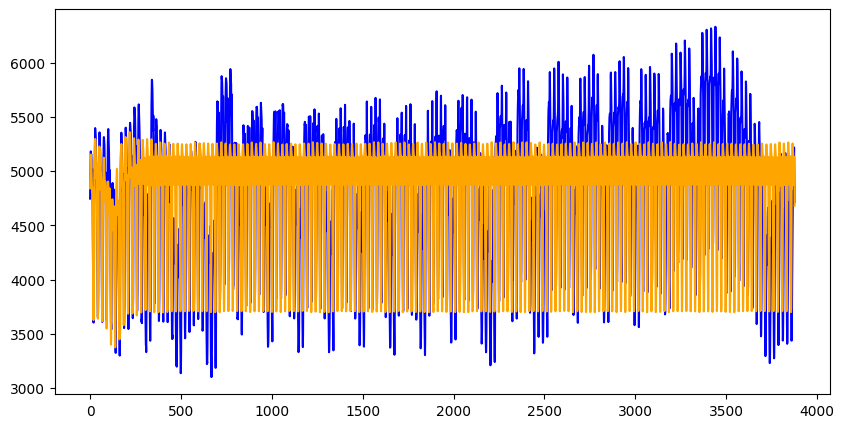

In [ ]:
electric_rf = electric.copy()
window_size = 60

electric_rf = electric_rf.iloc[:int(len(electric_rf) * 0.2)]
electric_rf = electric_rf.dropna()

train = electric_rf[:int(len(electric_rf) * 0.85)]
test = electric_rf[int(len(electric_rf) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

walk = test['Value'].values[:window_size].copy()
pred = []
for i in range(len(test['Value']) - window_size):
    x = walk.reshape(1, -1)
    p = model.predict(x)[0]
    pred.append(p)
    walk = np.append(walk[1:], p)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


MSE: 0.007290316631817687
RMSE: 0.0853833510224194
MAE: 0.07912308786756644
R2 Score: 0.9854169246787576


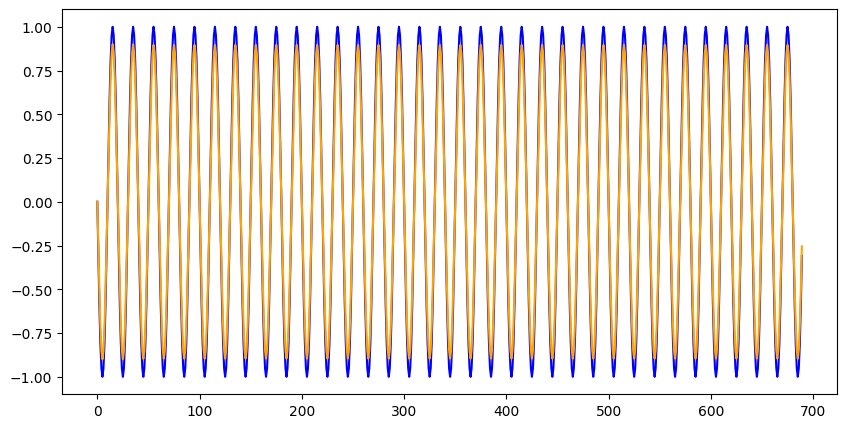

In [ ]:
#svr szinusz

szinusz_svr = szinusz.copy()
window_size = 60

train = szinusz_svr[:int(len(szinusz_svr) * 0.85)]
test = szinusz_svr[int(len(szinusz_svr) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

model = SVR(kernel='rbf', C=100, epsilon=0.1)
model.fit(X, y)

walk = test['Value'].values[:window_size].copy()
pred = []
for i in range(len(test['Value']) - window_size):
    x = walk.reshape(1, -1)
    p = model.predict(x)[0]
    pred.append(p)
    walk = np.append(walk[1:], p)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


MSE: 113400.83604672388
RMSE: 336.75040615673186
MAE: 297.59564018427045
R2 Score: -4.62389468488953


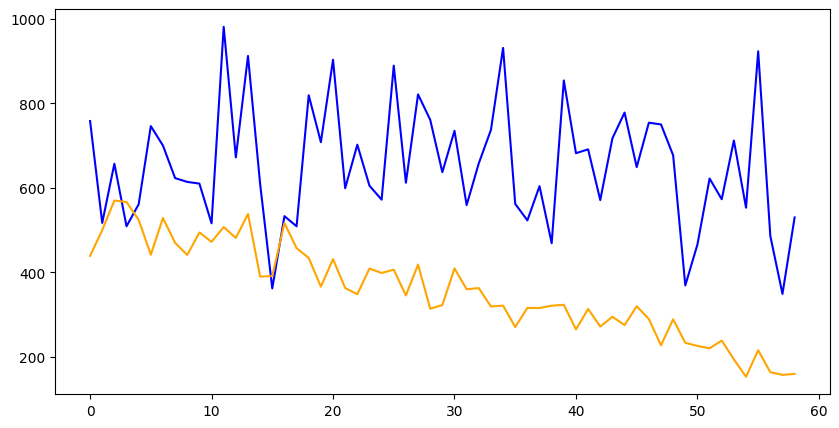

In [ ]:
#svr guest
guest_svr = guest2.copy()
window_size = 60

train = guest_svr[:int(len(guest_svr) * 0.85)]
test = guest_svr[int(len(guest_svr) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

model = SVR(kernel='rbf', C=100, epsilon=0.1)
model.fit(X, y)

walk = test['Value'].values[:window_size].copy()
pred = []
for i in range(len(test['Value']) - window_size):
    x = walk.reshape(1, -1)
    p = model.predict(x)[0]
    pred.append(p)
    walk = np.append(walk[1:], p)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


MSE: 597041.5384487003
RMSE: 772.6846306538654
MAE: 585.4699832350088
R2 Score: -0.6456257712250986


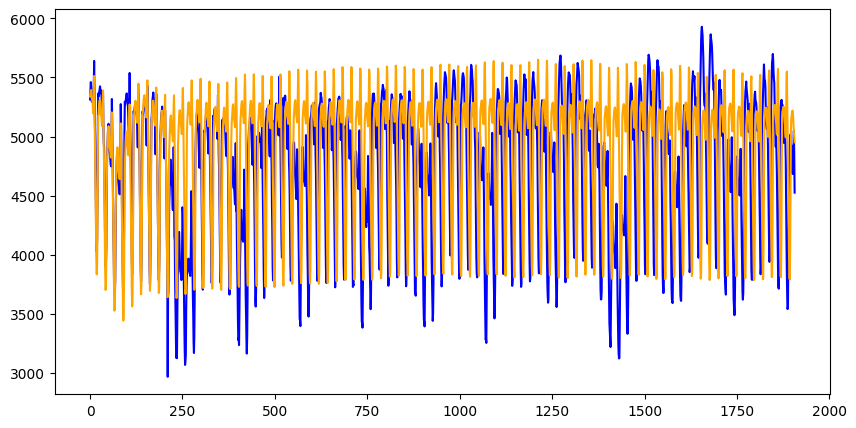

In [ ]:
electric_svr = electric.copy()
window_size = 60

electric_svr = electric_svr.iloc[:int(len(electric_svr) * 0.1)]
electric_svr = electric_svr.dropna()

train = electric_svr[:int(len(electric_svr) * 0.85)]
test = electric_svr[int(len(electric_svr) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

model = SVR(kernel='rbf', C=100, epsilon=0.1)
model.fit(X, y)

walk = test['Value'].values[:window_size].copy()
pred = []
for i in range(len(test['Value']) - window_size):
    x = walk.reshape(1, -1)
    p = model.predict(x)[0]
    pred.append(p)
    walk = np.append(walk[1:], p)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


MSE: 496979.3004517508
RMSE: 704.9675882278211
MAE: 525.6654081759467
R2 Score: -0.16545953556648008


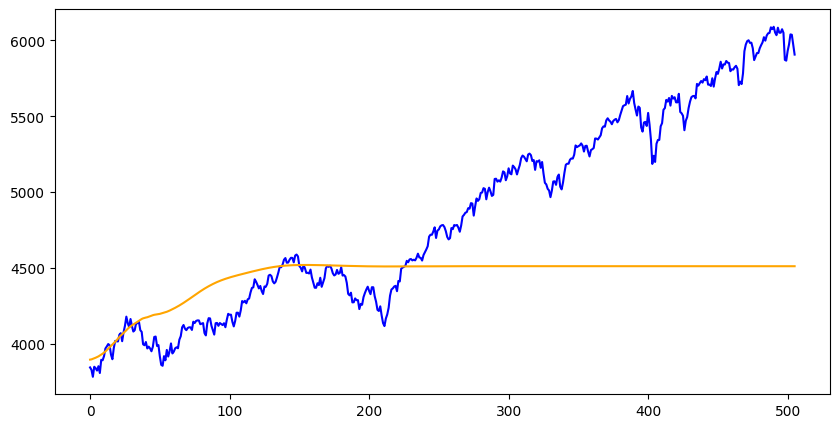

In [ ]:
#svr-sp
sp_svr = sp.copy()
window_size = 60

train = sp_svr[:int(len(sp_svr) * 0.85)]
test = sp_svr[int(len(sp_svr) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], -1)

model = SVR(kernel='rbf', C=100, epsilon=0.1)
model.fit(X, y)

predict_input = test['Value'].values[:window_size].copy()
pred = []
for i in range(len(test['Value']) - window_size):
    x = walk.reshape(1, -1)
    p = model.predict(x)[0]
    pred.append(p)
    predict_input = np.append(predict_input[1:], p)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1928
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5807e-06
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.5387e-06
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0877e-06
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5928e-06
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5493e-06
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0948e-06
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5971e-06
Epoch 9/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2881e-06
Epoch 10/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8852e-07
Epoch 11/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7710e-07
Epoch 12/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3847e-07
Epoch 13/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5451e-07
Epoch 14/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8888e-07
Epoch

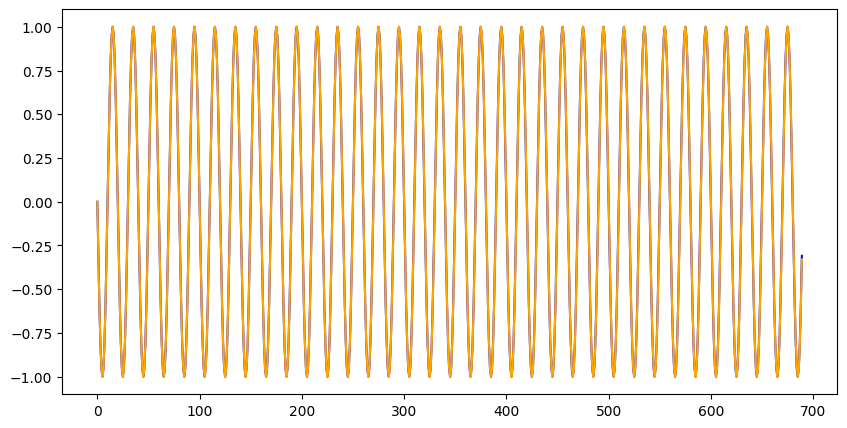

In [ ]:
szinusz_lstm = szinusz.copy()
window_size = 60

train = szinusz_lstm[:int(len(szinusz_lstm) * 0.85)]
test = szinusz_lstm[int(len(szinusz_lstm) * 0.85):]

all = train['Value'].values
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)

X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=30, batch_size=32, verbose=1)

predict_input = test['Value'].values[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(test['Value']) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

realdata = test['Value'].values[window_size:]

mse = mean_squared_error(realdata, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, pred)
rsq = r2_score(realdata, pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(pred, color='orange')
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8561
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6424
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6840
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6928
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7879
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7317
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6835
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6495
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6738
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7208
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6781
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6754
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7655
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6847
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7108
Epoch 16/100
20

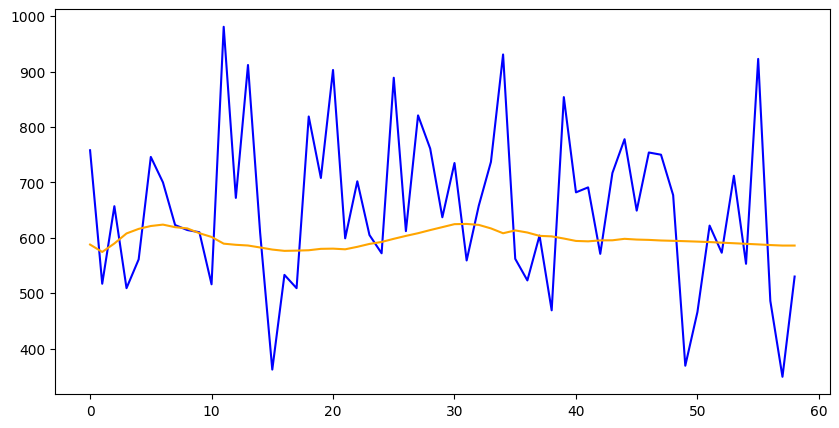

In [ ]:
guest_lstm = guest2.copy()
window_size = 60

guest_lstm = guest_lstm.dropna()
train = guest_lstm[:int(len(guest_lstm) * 0.85)]
test = guest_lstm[int(len(guest_lstm) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=100, batch_size=32, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2003
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0077
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0053
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055
Epoch 13/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051
Epoch 14/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051
Epoch 15/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042
Epoc

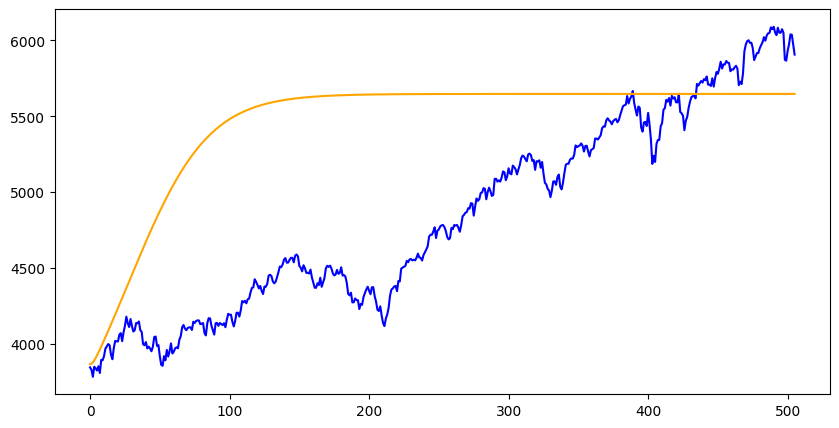

In [ ]:
sp_lstm = sp.copy()
window_size = 60

sp_lstm = sp_lstm.dropna()
train = sp_lstm[:int(len(sp_lstm) * 0.85)]
test = sp_lstm[int(len(sp_lstm) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=100, batch_size=32, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5311
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0733
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0591
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0499
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0420
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0353
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0302
Epoch 8/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0304
Epoch 9/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0324
Epoch 10/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0275
Epoch 11/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0265
Epoch 12/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0265
Epoch 13/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0240
Epoch 14/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0261
Epoch 15/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step -

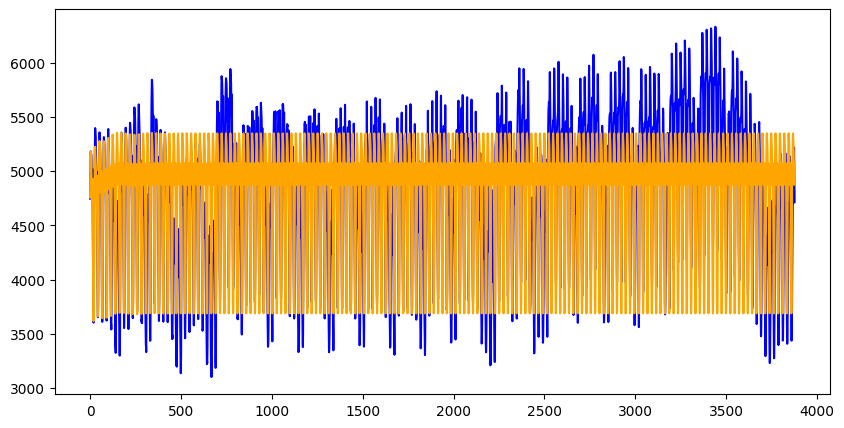

In [ ]:
electric_lstm = electric.copy()
window_size = 60

electric_lstm = electric_lstm.iloc[:int(len(electric_lstm) * 0.2)]
electric_lstm = electric_lstm.dropna()

train = electric_lstm[:int(len(electric_lstm) * 0.85)]
test = electric_lstm[int(len(electric_lstm) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=100, batch_size=128, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3995
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0057
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0038
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034
Epoch 12/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036
Epoch 13/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035
Epoch 14/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032
Epoch 15/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

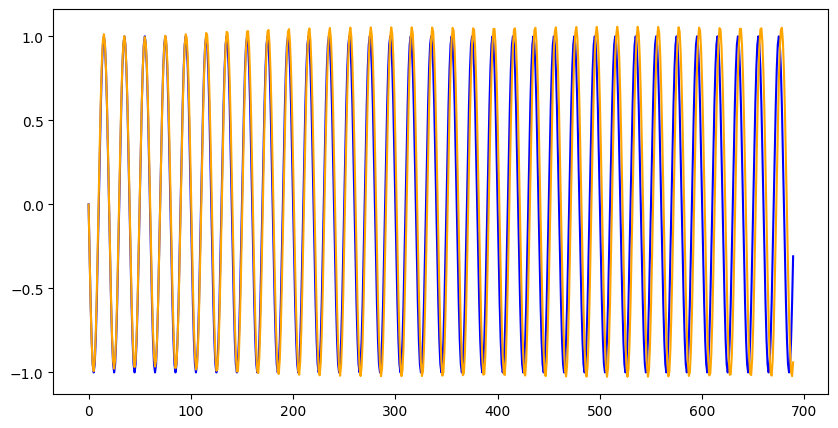

In [ ]:
#gru-szinusz

szinusz_gru = szinusz.copy()
window_size = 60

szinusz_gru = szinusz_gru.dropna()
train = szinusz_gru[:int(len(szinusz_gru) * 0.85)]
test = szinusz_gru[int(len(szinusz_gru) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(GRU(100, activation='tanh', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=100, batch_size=32, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8884
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7044
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7424
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6463
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6691
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7068
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6619
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6902
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7888
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7042
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7132
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6725
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6787
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7050
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7145
Epoch 16/50
20/20 ━━━━━━━━━━━━

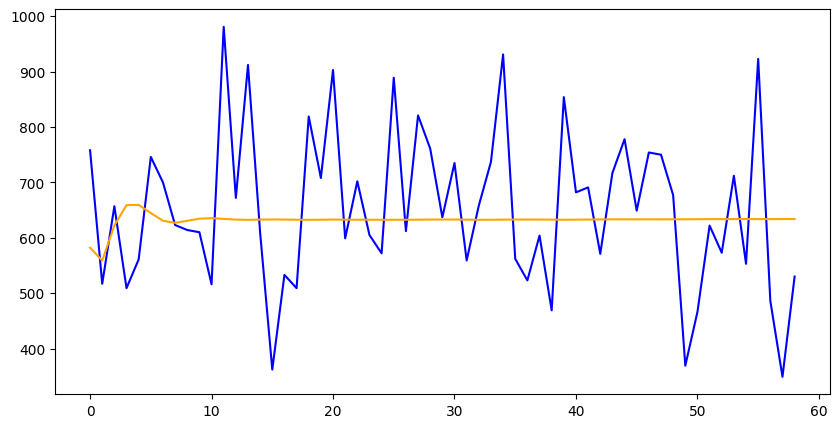

In [ ]:
guest_gru = guest2.copy()
window_size = 60

guest_gru = guest_gru.dropna()
train = guest_gru[:int(len(guest_gru) * 0.85)]
test = guest_gru[int(len(guest_gru) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(GRU(100, activation='tanh', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=32, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4251
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0761
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0538
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0484
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0414
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0399
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0384
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0361
Epoch 9/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0437
Epoch 10/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0310
Epoch 11/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0323
Epoch 12/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0303
Epoch 13/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0263
Epoch 14/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0269
Epoch 15/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251


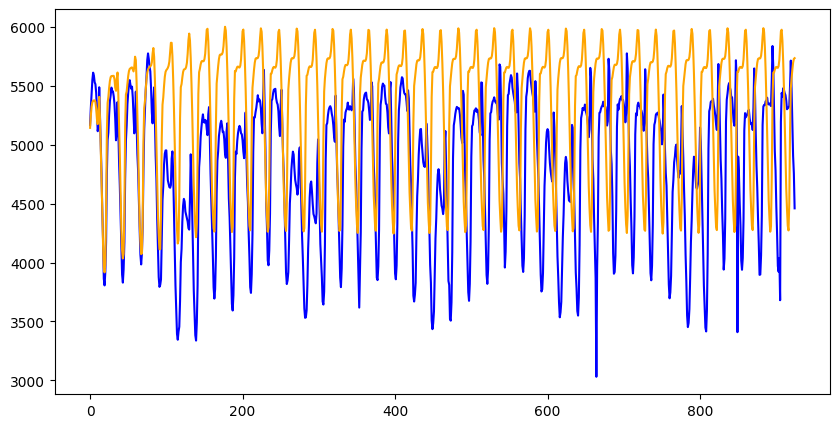

In [ ]:
electric_gru = electric.copy()
window_size = 60

electric_gru = electric_gru.iloc[:int(len(electric_gru) * 0.05)]
electric_gru = electric_gru.dropna()

train = electric_gru[:int(len(electric_gru) * 0.85)]
test = electric_gru[int(len(electric_gru) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(GRU(100, activation='tanh', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=32, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2904
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0056
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0038
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042
Epoch 10/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043
Epoch 11/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042
Epoch 12/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041
Epoch 13/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041
Epoch 14/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037
Epoch 15/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

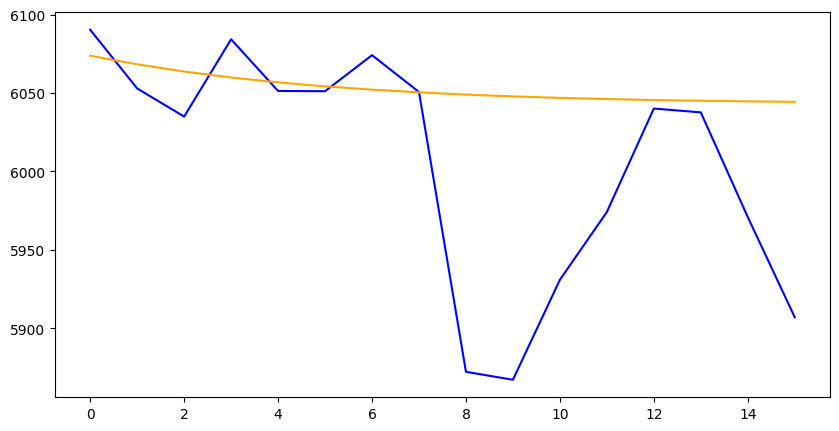

In [ ]:
sp_gru = sp.copy()
window_size = 60

sp_gru = sp_gru.dropna()
train = sp_gru[:int(len(sp_gru) * 0.98)]
test = sp_gru[int(len(sp_gru) * 0.98):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(GRU(100, activation='tanh', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=100, batch_size=32, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1092
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6716e-04
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0985e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7331e-04
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6107e-04
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2280e-04
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4135e-04
Epoch

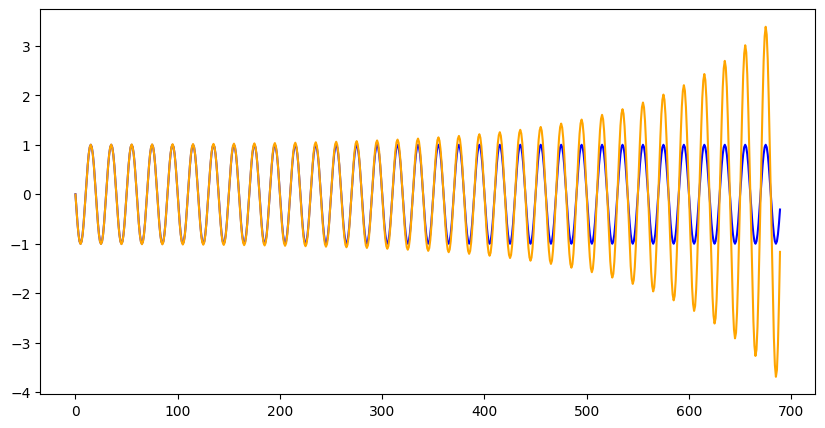

In [ ]:
szinusz_cnn = szinusz.copy()
window_size = 60

szinusz_cnn = szinusz_cnn.dropna()
train = szinusz_cnn[:int(len(szinusz_cnn) * 0.85)]
test = szinusz_cnn[int(len(szinusz_cnn) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=64, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.8246
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5732 
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5034 
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5371 
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4370 
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4317 
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3882 
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3367 
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3132 
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3405 
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2817 
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2732 
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2219 
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1625 
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2913 
E

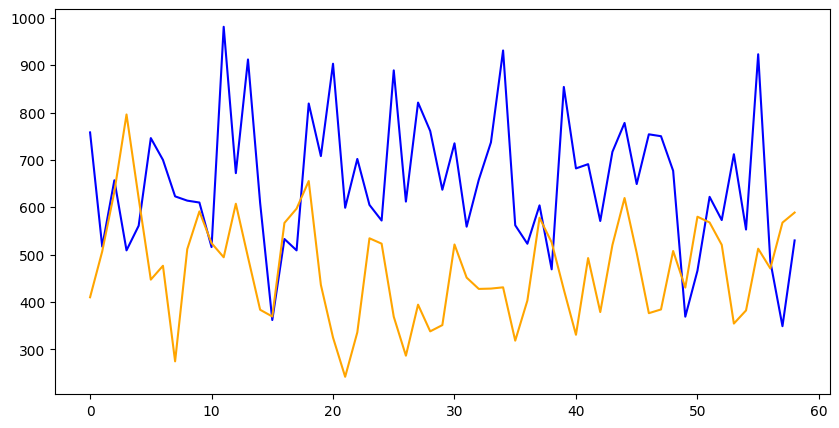

In [ ]:
guest_cnn = guest2.copy()
window_size = 60

guest_cnn = guest_cnn.dropna()
train = guest_cnn[:int(len(guest_cnn) * 0.85)]
test = guest_cnn[int(len(guest_cnn) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=100, batch_size=32, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2151
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0437
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0340
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173
Epoch 15/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137
Epoch 16/50
87/87 ━━━━━━━━━━━

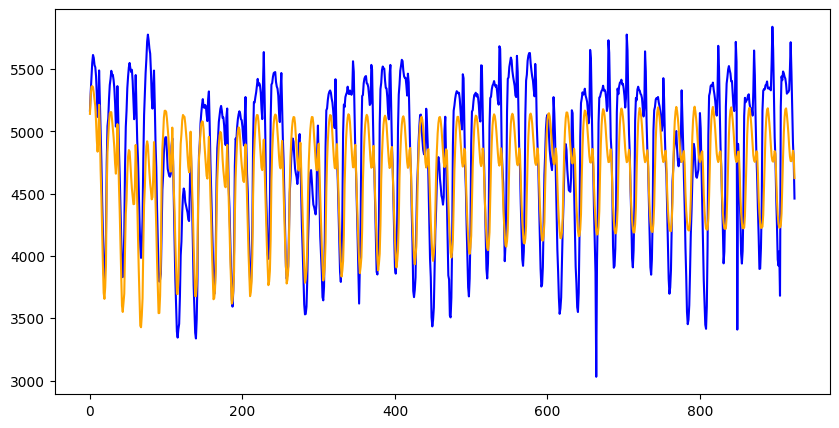

In [ ]:
electric_cnn = electric.copy()
window_size = 60

electric_cnn = electric_cnn.iloc[:int(len(electric_cnn) * 0.05)]
electric_cnn = electric_cnn.dropna()
train = electric_cnn[:int(len(electric_cnn) * 0.85)]
test = electric_cnn[int(len(electric_cnn) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=64, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1429
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 16/50
50/50 ━━━━━━━━━━━

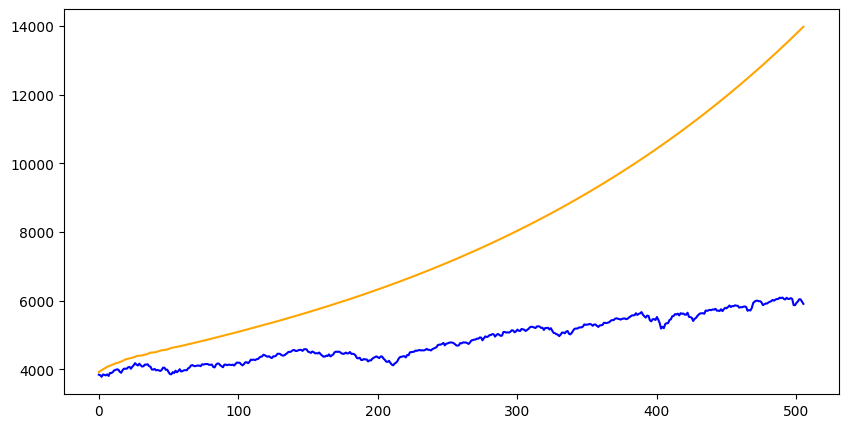

In [ ]:
sp_cnn = sp.copy()
window_size = 60

sp_cnn = sp_cnn.dropna()
train = sp_cnn[:int(len(sp_cnn) * 0.85)]
test = sp_cnn[int(len(sp_cnn) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=64, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6723
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0174
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068
Epoch 16/50
66/66 ━━━━━━━━━━━━

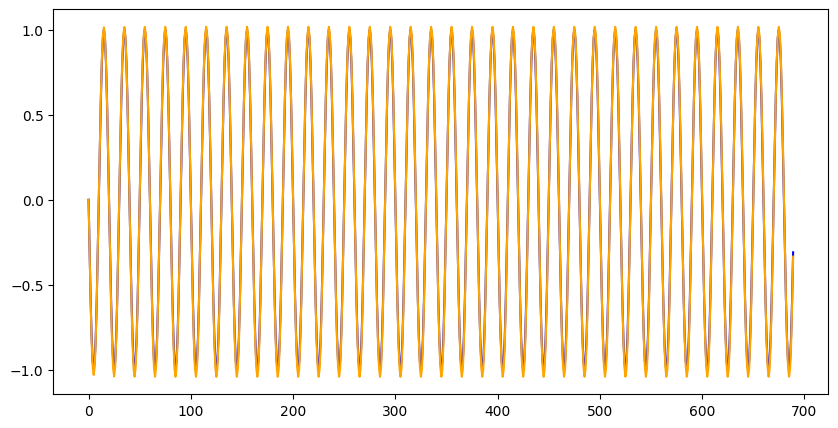

In [ ]:
szinusz_cnnlstm = szinusz.copy()
window_size = 60

szinusz_cnnlstm = szinusz_cnnlstm.dropna()
train = szinusz_cnnlstm[:int(len(szinusz_cnnlstm) * 0.85)]
test = szinusz_cnnlstm[int(len(szinusz_cnnlstm) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=64, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9038
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6660 
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7128 
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6999 
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7116 
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6498
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7538 
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7554 
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6920 
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7350 
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7221 
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7142 
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6346 
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7314 
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7118 
Epoch 16/50
10/1

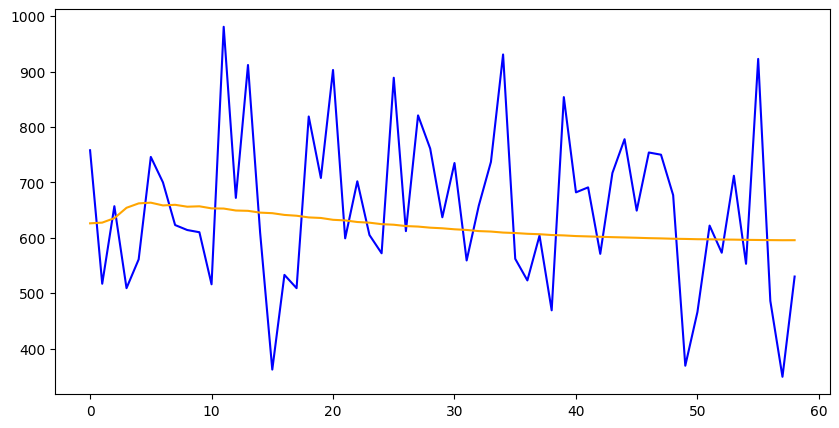

In [ ]:
guest_cnnlstm = guest2.copy()
window_size = 60

guest_cnnlstm = guest_cnnlstm.dropna()
train = guest_cnnlstm[:int(len(guest_cnnlstm) * 0.85)]
test = guest_cnnlstm[int(len(guest_cnnlstm) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=64, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7180
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1435
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0879
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0635
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0601
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0574
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0545
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0510
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0539
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0430
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0437
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0420
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0409
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0382
Epoch 15/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0364
Epoch 16/50
87/87 ━━━━━━━━━━━━

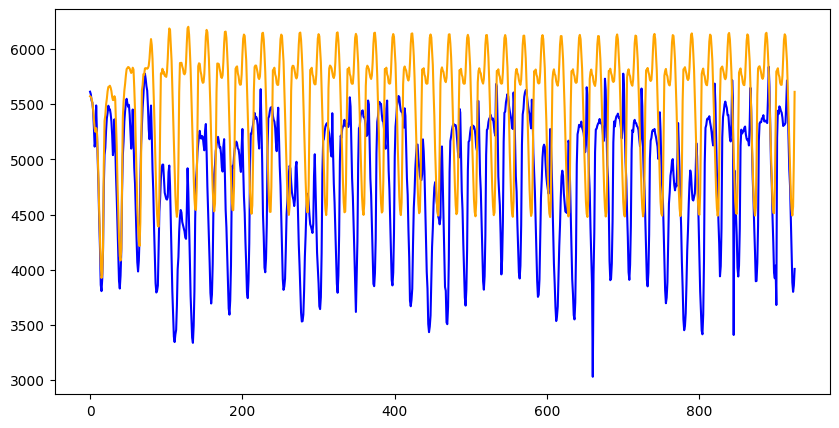

In [ ]:
electric_cnnlstm = electric.copy()
electric_cnnlstm = electric_cnnlstm.dropna()
electric_cnnlstm = electric_cnnlstm.iloc[:int(len(electric_cnnlstm) * 0.05)]

window_size = 60

train = electric_cnnlstm[:int(len(electric_cnnlstm) * 0.85)]
test = electric_cnnlstm[int(len(electric_cnnlstm) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=64, verbose=1, callbacks=[early])

predict_input = stest[:window_size].reshape(1, window_size, 1)
pred = []
for i in range(len(stest) - window_size):
    p = model.predict(predict_input, verbose=0)[0][0]
    pred.append(p)
    new_input = np.array([[[p]]])
    predict_input = np.append(predict_input[:, 1:, :], new_input, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
rsq = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {rsq}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3128
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091
Epoch 16/50
50/50 ━━━━━━━━━━━━

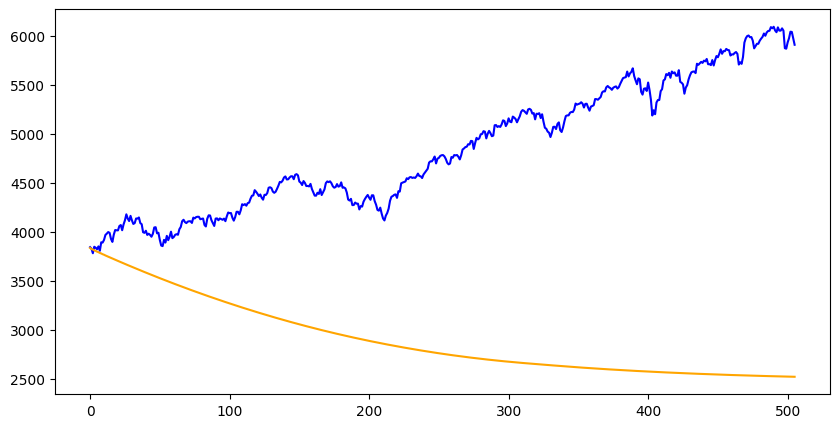

In [ ]:
sp_cnnlstm = sp.copy()
sp_cnnlstm = sp_cnnlstm.dropna()

window_size = 60

train = sp_cnnlstm[:int(len(sp_cnnlstm) * 0.85)]
test = sp_cnnlstm[int(len(sp_cnnlstm) * 0.85):]

s = StandardScaler()
strain = s.fit_transform(train[['Value']])
stest = s.transform(test[['Value']])

all = strain.flatten()
X, y = [], []
for i in range(window_size, len(all)):
    X.append(all[i - window_size:i])
    y.append(all[i])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=64, verbose=1, callbacks=[early])

X_input = stest[:window_size].reshape(1, window_size, 1)
pred = []

for i in range(len(stest) - window_size):
    p = model.predict(X_input, verbose=0)[0][0]
    pred.append(p)
    new = np.array([[[p]]])
    X_input = np.append(X_input[:, 1:, :], new, axis=1)

predict2 = s.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
realdata = s.inverse_transform(stest[window_size:].reshape(-1, 1)).flatten()

mse = mean_squared_error(realdata, predict2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realdata, predict2)
r2 = r2_score(realdata, predict2)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(10, 5))
plt.plot(realdata, color='blue')
plt.plot(predict2, color='orange')
plt.show()
